# PAMAP2 DataSet - Classification Problem

### About The Data Set:

The PAMAP2 Physical Activity Monitoring dataset contains: 
* Data of 18 different physical activities (such as walking, cycling, playing soccer, etc.)
* Performed by 9 subjects 
* 3 units wearing inertia measurement and heart rate monitor

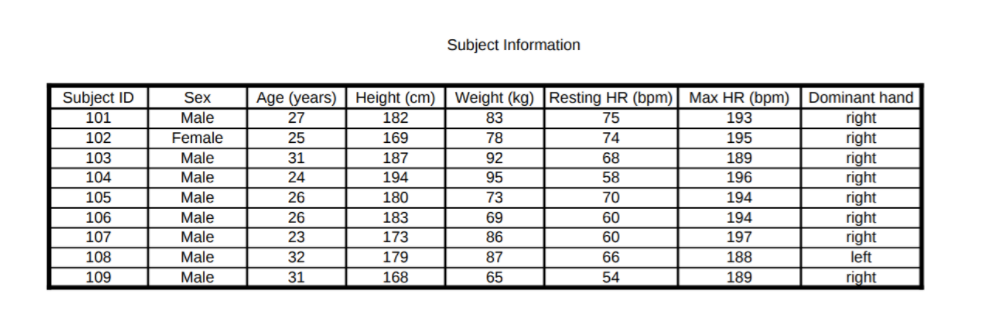

## Part 0: Imports 

In [1]:
# basic
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from matplotlib import pyplot as plt
from IPython.display import display

# split data
from sklearn.preprocessing import MinMaxScaler

Instructions for updating:
non-resource variables are not supported in the long term


## Part 1: Load the data from the data set

In [2]:
#load_activity_map - get the map of humen acctivities describe in the data set

def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [3]:
#generate_three_IMU - genetrate 3 columns of x, y, z data

def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

In [4]:
#generate_four_IMU - genetrate 4 columns of x, y, z, w data

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

In [5]:
#generate_cols_IMU - for a given name generate 5 columns of the sensors as describe in the data set (accelmoter 16, 6, gyroscope, magnometer and orentaion

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

In [6]:
#load_IMU - load all 52 columns of a subject in the data set

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

In [7]:
#load_subjects - load all subjects from a given root

def load_subjects(root='C:/Users/moria/Desktop/Project-PAMAP2/Data/Protocol/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,110):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

In [8]:
data = load_subjects()

In [9]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,109
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,109
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,109
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,109


## Part 2: Optimize our data

1. We will take every NaN value and eplace it with the mean value of the column.

2. We will note from the map that acitvity_id = 0 is not an valid activity.

In [10]:
def fix_data(data):
    
    # define activity_id = 0 is not a valid activity
    index_to_del = data[data['activity_id']==0].index
    data = data.drop(index_to_del)
    data = data.interpolate()
    
    # fill all the NaN values 
    for col_name in data.columns:
        mean_col = data[col_name].mean()
        data[col_name] = data[col_name].fillna(mean_col)
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

In [11]:
data = fix_data(data)

In [12]:
data.describe()

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


## Part 3: Balance Analysis

check for each subject if there equal number of sampels.

## Part 4: Validation strategy - train & test Split

Subject 107, 108 are having the most measurments in all activities, we will take them as our test train. 

As Part of our spliting we will use min_max_scaler that takes all column in the data set and rescaling them between 0 to 1, for getting better results more quickly.

In [13]:
def split_train_test(data):
    
    # create the test data
    subject107 = data[data['id'] == 107]
    subject108 = data[data['id'] == 108]
    test = subject107.append(subject108)

    # create the train data
    train = data[data['id'] != 107]
    train = data[data['id'] != 108]

    # drop the columns id and time
    test = test.drop(["id"], axis=1)
    train = train.drop(["id"], axis=1)

    # split train and test to X and y
    X_train = train.drop(['activity_id','time_stamp'], axis=1).values
    X_test = test.drop(['activity_id','time_stamp'], axis=1).values
    
    # make data scale to min max beetwin 0 to 1
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaler.fit(X_test)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = train['activity_id'].values
    y_test = test['activity_id'].values
    return X_train, X_test, y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = split_train_test(data)
print('X_Train shape:',X_train.shape,'\nY_Train shape: ',y_train.shape)
print('X_Test shape:',X_test.shape,'\nY_Test shape: ',y_test.shape)

X_Train shape: (1680770, 52) 
Y_Train shape:  (1680770,)
X_Test shape: (494878, 52) 
Y_Test shape:  (494878,)


## Part 5: Naive solution

Pre-processing the data - we will use base line of grouping all the data by activities.

In [15]:
def base_line_preprocess(data):
    train = data.groupby('activity_id')
    X_base = train.mean().reset_index().drop(['activity_id','id','time_stamp'],axis=1).values
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_base)
    X_base = min_max_scaler.transform(X_base)
    y_base = np.array(train['activity_id'].unique().explode().values).astype('float64')
    return X_base, y_base

In [40]:
X_base, y_base = base_line_preprocess(data)
print('X_base shape: ',X_base.shape)
print('y_base shape: ',y_base.shape)

X_base shape:  (12, 52)
y_base shape:  (12,)


In [41]:
print(X_base)

[[0.         0.67426968 1.         0.         0.90300508 1.
  0.         0.91483991 0.49332339 0.19394666 0.63055092 0.
  1.         0.14620603 1.         0.17156837 1.         1.
  0.42943385 1.         0.         1.         0.97989079 0.
  1.         0.32013477 0.5339362  0.712681   1.         1.
  0.         1.         1.         0.35639844 0.41950179 0.38700165
  0.         0.         0.         0.         0.         0.
  0.53498832 0.63624066 0.2120451  1.         1.         0.
  0.39628343 0.63595458 1.         0.        ]
 [0.05173304 0.79447976 0.63303069 0.47384219 0.74726561 0.63693654
  0.51750867 0.76040217 0.49835686 0.19594786 0.61847818 0.10186061
  0.32643819 0.50288725 0.84459193 0.08591159 0.6836199  0.70703051
  0.64276058 0.75205296 0.96948021 0.48158362 0.74815941 0.96939348
  0.48700097 0.3467877  0.52674861 0.71868411 0.2636678  0.31656971
  0.37364118 0.59451772 0.03227854 0.52511955 0.46958744 0.66212885
  0.63581255 0.66201733 0.54196676 0.65329555 0.65656186 

### LogisticRegression || SoftMax
Training and Fitting 

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss

reg = LogisticRegression()
reg.fit(X_base, y_base)
print(X_base.shape)
print(y_base.shape)

preds = reg.predict(X_train)
print('Logistic regression X_train shape: ', preds.shape)
print('Logistic regression accuracy on train: ', accuracy_score(y_train,preds)*100)

preds = reg.predict(X_test)
print('Logistic regression X_test shape: ', preds.shape)
print('Logistic regression accuracy on test: ', accuracy_score(y_test,preds)*100)

(12, 52)
(12,)
Logistic regression X_train shape:  (1680770,)
Logistic regression accuracy on train:  42.729820260951826
Logistic regression X_test shape:  (494878,)
Logistic regression accuracy on test:  33.45228520968804


In [43]:
features = X_test.shape[1] # num of cols
labels = 18 # possible res 
learning_rate = 1/1000
training_epoch = 1000
batch_size = 5
displey_set = 1

In [46]:
x = tf.placeholder(tf.float32, [None, features])
y = tf.placeholder(tf.float32, [None, labels])

# weight
w = tf.Variable(tf.truncated_normal([features, labels]))

# Bias
b = tf.Variable(tf.constant(0.1, shape=[labels]))

In [52]:
pred = tf.nn.softmax(tf.matmul(x, w) + b)

# loss function - minimize error
loss = tf.reduce_mean(-tf.reduce_sum(y*tf.log(y), reduction_indices=[1]))

# update function
update = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

train_pred = tf.nn.softmax(pred)
valid_pred = tf.nn.softmax(tf.matmul(x, w) )

# init
# init = tf.global_variables_initializer()

ValueError: No gradients provided for any variable, check your graph for ops that do not support gradients, between variables ["<tf.Variable 'Variable:0' shape=(52, 18) dtype=float32_ref>", "<tf.Variable 'Variable_1:0' shape=(52, 18) dtype=float32_ref>", "<tf.Variable 'Variable_2:0' shape=(52, 18) dtype=float32_ref>", "<tf.Variable 'Variable_3:0' shape=(18,) dtype=float32_ref>"] and loss Tensor("Mean_4:0", shape=(), dtype=float32).

### Train

In [ ]:
def accuracy(pred, labels):
    correct_pred = np.sum(np.argmax(pred, 1) == np.argmax(labels, 1))
    acc = (100.0 * pred)/pred.shape[0]
    return acc

In [ ]:
sess = tf.Session()

sess.run(init)

for i in range(training_epoch):
    sess.run(update, feed_dict = {x: X_test, y: y_test}) #BGD

In [ ]:
with tf.Session() as sess:
    
    # run to init
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # training
    for epoch in range(training_epoch):
        avg_cost = 0.0
        avg_acc = 0.0
        total_batch = len(X_train)//batch_size
        
        for i in range(total_batch):
            batch_x = X_train[i:i+1+batch_size]
            batch_y = X_train[i:i+1+batch_size]
            
            _, c = sess.run([update, loss], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c/total_batch
            
            pred_y = sess.run(pred, feed_dict={x: batch_x})
            acc = accuracy(pred_y, batch_y)
            avg_acc += acc/total_batch
            
        if (epoch+1)%display_step==0:
            tc = sess.run(loss, feed_dict={x: X_test, y: y_test})
            pred_y = sess.run(loss, feed_dict={x: X_test})
            ta = accuracy(pred_y, y_test)
            
            print("Epoch: {:2.0f} - Cost: {:1.5f} - Acc: {:0.5f} - TestCost: {:0.5f} - TestAcc{:0.5f}".format(epoch+1, avg_cost,avg_acc, tc, ta))
            
        print("Optimization Finnished")
        
        # test model
        correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        
        # calculate accuracy
        acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        print("Test Accuracy: ", acc.eval({x: X_test, y: y_test}))